In [1]:
import sys, os, glob
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import logging
# from scipy.interpolate import UnivariateSpline, interp1d
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison
from statsmodels.stats.libqsturng import psturng
import scipy.stats as stats

# logging.basicConfig(stream=sys.stdout, format='%(asctime)s - %(levelname)s - %(message)s', level=logging.DEBUG)
logging.basicConfig(stream=sys.stdout, format='%(asctime)s - %(levelname)s - %(message)s', level=logging.INFO)

%matplotlib inline
font = {'family' : 'Arial',
        'size'   : 7}
matplotlib.rc('font', **font)
plt.rcParams['svg.fonttype'] = 'none'

# Make a folder if it is not already there to store exported figures
!mkdir ../jupyter_figures

# Make a folder to store cleaned up data frames for more advanced statistical analysis in R.
# This is only necessary because exact p values were required by the journal, whereas the
# psturng in statsmodels.stats.libqsturng was bound by 0.001 and 0.9.
# Practically, nobody really cares about exact p values when p < 0.001 and p > 0.9, but got to get it when asked.
!mkdir ../data_cleaned


mkdir: ../jupyter_figures: File exists
mkdir: ../data_cleaned: File exists


In [2]:
# Facility Functions

def tukeyTest(data, groups, alpha=0.05):
    '''Perform pairwise Tukey test for the data by groups
    '''
    # pairwise comparisons using Tukey's test, calculating p-values
    res = pairwise_tukeyhsd(data, groups, alpha)
    print("Summary of test:\n", res)
    # print(dir(results))# prints out all attributes of an object
    pVal = psturng(np.abs(res.meandiffs / res.std_pairs), len(res.groupsunique), res.df_total)
    print("p values of all pair-wise tests:\n", pVal)

    return res

def plotDensityBarSwarm(groups, density, outputFigPath, yTickSpacing=30,
                        plot_order=["sg-Control", "sg1-Cdh1", "sg2-Cdh1", "sg-Itgb1"],
                        yMax=None, yTicks=None, fig_width=0.7, fig_height=1.0):
    '''plot bar and swarm plots of cell density data, save .svg as outputFigPath
    
    Note: error bar here is 95% confidence interval by bootstrapping
    '''
    
    fig = plt.figure(figsize=(fig_width,fig_height), dpi=300)
    ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
    
    ax = sns.swarmplot(groups, density, color="blue", size=1, alpha=.6,
                  order=plot_order)

    ax = sns.barplot(groups, density, color="Gray", alpha=1.0,
                errwidth=.7, errcolor="k", capsize=.2, ci=95,
                order=plot_order)

    if yMax == None:
        yMax = int(max(density)/5 + 1) * 5
    if yTicks == None:
        spacing = yTickSpacing
        yTicks = [spacing*i for i in range(int(yMax/spacing) + 1)]
    
    plt.ylim(0, yMax)
    plt.yticks(yTicks)
    
    plt.xlabel(None)
#     plt.ylabel("Attached cells / $mm^2$")
    plt.ylabel("Attached cells / mm2")
    
    ax.set_xticklabels(labels=plot_order, rotation=45, ha="right")

    for o in fig.findobj():
        o.set_clip_on(False)
    for o in ax.findobj():
        o.set_clip_on(False)

    plt.savefig(outputFigPath)
    

    return ax

In [3]:
# The density when 1E5 total cells evenly attached to a circular area with 35 mm diamter
DENSITY_UPPER = 1E5 / (np.pi*17.5*17.5)
DENSITY_UPPER


103.93792201919696

In [4]:
# This is the normalization constant in square mm
# Every Filed of view (FOV) is identical with 2048x2044 pixels
# The pixel size is 0.65 um
FOV_AREA = 2048 * 0.65 * 2044 * 0.65 / 1000 / 1000
FOV_AREA


1.7686323200000005

In [5]:
# Read in and clean up the data for 2 hour fixed E-cadherin coated surface
# 
# Each spreadsheet contains two columns: file name and the cell counts
#
# Each experimental condition has 3 or 4 replicates (3 or 4 wells), each
# well we had taken 13 fields of view images
#
# Nomenclature:
#
# cell_line    D193    D267     D266     D301
# cell_id*     1       2        3        4
# sgRNA        Control sg1-Cdh1 sg2-Cdh1 sg-Itgb1
#
# * cell_id is used for denoting the wells.
# For example, 1-1, 1-2, 1-3 and 1-4 denote 4 wells (replicates) for cell line #1, which is D193

folder = "../data/cell-attachment-assay-count-data/"

fileList = glob.glob(folder + "20200205-Ecad-coating-cell-attachment-2h*.txt")
fileList.sort()
fileList

# 1. 20200205-Ecad-coating-cell-attachment-2h-D193-D301-plate3-1well-each-splitPositions-cell-counts.txt
df = pd.read_csv(fileList[0], header=0, sep="\t")
incubation_time = 2 * 13 * ["2h"]
cell_line = 1 * 13 * ["D193"] + 1 * 13 * ["D301"]
sgRNA = 1 * 13 * ["sg-Control"] + 1 * 13 * ["sg-Itgb1"]
# This is the extra plate in which we did one extra well each for D193 and D301
wells = 13 * ["1-4"] + 13 * ["4-4"]
df["incubation_time"] = incubation_time
df["cell_line"] = cell_line
df["sgRNA"] = sgRNA
df["wells"] = wells
df1 = df

# 2. 20200205-Ecad-coating-cell-attachment-2h-D193-plate1-3wells-splitPositions-cell-counts.txt
df = pd.read_csv(fileList[1], header=0, sep="\t")
incubation_time = 3 * 13 * ["2h"]
cell_line = 3 * 13 * ["D193"]
sgRNA = 3 * 13 * ["sg-Control"]
wells = 13 * ["1-1"] + 13 * ["1-2"] + 13 * ["1-3"]
df["incubation_time"] = incubation_time
df["cell_line"] = cell_line
df["sgRNA"] = sgRNA
df["wells"] = wells
df2 = df

# 3. 20200205-Ecad-coating-cell-attachment-2h-D266-plate2-3wells-splitPositions-cell-counts.txt
df = pd.read_csv(fileList[2], header=0, sep="\t")
incubation_time = 3 * 13 * ["2h"]
cell_line = 3 * 13 * ["D266"]
sgRNA = 3 * 13 * ["sg2-Cdh1"]
wells = 13 * ["3-1"] + 13 * ["3-2"] + 13 * ["3-3"]
df["incubation_time"] = incubation_time
df["cell_line"] = cell_line
df["sgRNA"] = sgRNA
df["wells"] = wells
df3 = df

# 4. 20200205-Ecad-coating-cell-attachment-2h-D267-plate1-3wells-splitPositions-cell-counts.txt
df = pd.read_csv(fileList[3], header=0, sep="\t")
incubation_time = 3 * 13 * ["2h"]
cell_line = 3 * 13 * ["D267"]
sgRNA = 3 * 13 * ["sg1-Cdh1"]
wells = 13 * ["2-1"] + 13 * ["2-2"] + 13 * ["2-3"]
df["incubation_time"] = incubation_time
df["cell_line"] = cell_line
df["sgRNA"] = sgRNA
df["wells"] = wells
df4 = df

# 5. 20200205-Ecad-coating-cell-attachment-2h-D301-plate2-3wells-splitPositions-cell-counts.txt
df = pd.read_csv(fileList[4], header=0, sep="\t")
incubation_time = 3 * 13 * ["2h"]
sgRNA = 3 * 13 * ["sg-Itgb1"]
wells = 13 * ["4-1"] + 13 * ["4-2"] + 13 * ["4-3"]
df["incubation_time"] = incubation_time
df["cell_line"] = cell_line
df["sgRNA"] = sgRNA
df["wells"] = wells
df5 = df


df = pd.concat([df1, df2, df3, df4, df5])
df.reset_index(inplace=True)
df.sort_values(by="cell_line", inplace=True)
df["cell_density"] = df.cell_number / FOV_AREA
df_Ecad_2h = df


2020-04-16 09:44:39,215 - INFO - NumExpr defaulting to 8 threads.


In [6]:
df.groupby("sgRNA")["cell_density"].describe()


,count,mean,std,min,25%,50%,75%,max
sgRNA,,,,,,,,
sg-Control,52.0,51.049877,27.036021,15.831442,31.097475,42.971057,63.043064,157.183603
sg-Itgb1,52.0,63.597599,19.580405,31.662884,48.483791,63.043064,75.199350,107.993051
sg1-Cdh1,39.0,5.973035,3.661499,1.130817,3.392452,4.523269,7.633017,16.962259
sg2-Cdh1,39.0,4.102837,2.550838,0.000000,2.261635,3.957861,5.088678,10.742764


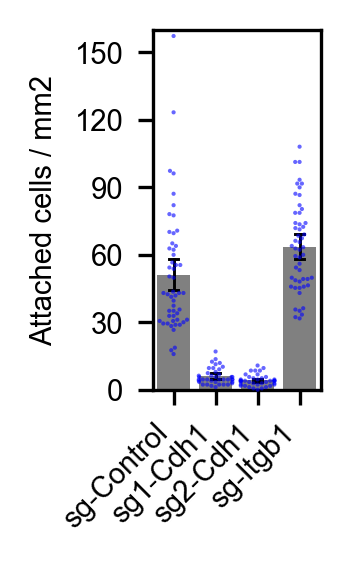

In [7]:
outputPrefix = "cell_attachment_Ecad_coating_2h_tall"
outputFigPath = "../jupyter_figures/" + outputPrefix + ".svg"
plotDensityBarSwarm(df.sgRNA, df.cell_density, outputFigPath,
                    yTickSpacing=30, yMax=160,
                   fig_width=0.7, fig_height=1.5)


In [8]:
# Save cleaned data for further statistical analysis in R
df['data_to_compare'] = df.cell_density
df['groups'] = df.sgRNA
df.to_csv('../data_cleaned/' + '20200205-Ecad-coating-cell-attachment-2h.csv')

# Filter out values close to the mean to select representative images
df1 = df[df.cell_number>=46] 
df2 = df1[df1.cell_number<56]
df2

# # Filter out values close to the mean to select representative images
# df1 = df[df.cell_number>=0] 
# df2 = df1[df1.cell_number<10]
# df2


,index,file_name,cell_number,incubation_time,cell_line,sgRNA,wells,cell_density,data_to_compare,groups
37,11,"Plate000_Well1_ChannelMono,GFP_Seq0000-11",52,2h,D193,sg-Control,1-1,29.401249,29.401249,sg-Control
50,24,"Plate000_Well2_ChannelMono,GFP_Seq0001-11",55,2h,D193,sg-Control,1-2,31.097475,31.097475,sg-Control
52,26,"Plate000_Well3_ChannelMono,GFP_Seq0002-00",54,2h,D193,sg-Control,1-3,30.532067,30.532067,sg-Control
53,27,"Plate000_Well3_ChannelMono,GFP_Seq0002-01",50,2h,D193,sg-Control,1-3,28.270432,28.270432,sg-Control
55,29,"Plate000_Well3_ChannelMono,GFP_Seq0002-03",52,2h,D193,sg-Control,1-3,29.401249,29.401249,sg-Control
59,33,"Plate000_Well3_ChannelMono,GFP_Seq0002-07",55,2h,D193,sg-Control,1-3,31.097475,31.097475,sg-Control
38,12,"Plate000_Well1_ChannelMono,GFP_Seq0000-12",51,2h,D193,sg-Control,1-1,28.835841,28.835841,sg-Control
4,4,"Plate000_Well1_ChannelMono,GFP_Seq0000-04",51,2h,D193,sg-Control,1-4,28.835841,28.835841,sg-Control
8,8,"Plate000_Well1_ChannelMono,GFP_Seq0000-08",54,2h,D193,sg-Control,1-4,30.532067,30.532067,sg-Control
9,9,"Plate000_Well1_ChannelMono,GFP_Seq0000-09",53,2h,D193,sg-Control,1-4,29.966658,29.966658,sg-Control


In [9]:
# Read in and clean up the data for 1 hour fixed E-cadherin coated surface
# 
# Each spreadsheet contains two columns: file name and the cell counts
#
# Each experimental condition has 3 replicates (3 wells), each well we had 
# taken 13 fields of view images.
# 
# Note that for D301, one well is in a separate plate because one well of
# the original plate had its glass coverslip fallen off during coating
#
# Nomenclature:
#
# cell_line    D193    D267     D266     D301
# cell_id*     1       2        3        4
# sgRNA        Control sg1-Cdh1 sg2-Cdh1 sg-Itgb1
#
# * cell_id is used for denoting the wells.
# For example, 1-1, 1-2, 1-3 and 1-4 denote 4 wells (replicates) for cell line #1, which is D193

folder = "../data/cell-attachment-assay-count-data/"

fileList = glob.glob(folder + "20200205-Ecad-coating-cell-attachment-1h*.txt")
fileList.sort()
fileList

# 1. 20200205-Ecad-coating-cell-attachment-1h-D193-plate1-3wells-splitPositions-cell-counts.txt
df = pd.read_csv(fileList[0], header=0, sep="\t")
incubation_time = 3 * 13 * ["1h"]
cell_line = 3 * 13 * ["D193"]
sgRNA = 3 * 13 * ["sg-Control"]
wells = 13 * ["1-1"] + 13 * ["1-2"] + 13 * ["1-3"]
df["incubation_time"] = incubation_time
df["cell_line"] = cell_line
df["sgRNA"] = sgRNA
df["wells"] = wells
df1 = df

# 2. 20200205-Ecad-coating-cell-attachment-1h-D266-plate2-3wells-splitPositions-cell-counts.txt
df = pd.read_csv(fileList[1], header=0, sep="\t")
incubation_time = 3 * 13 * ["1h"]
cell_line = 3 * 13 * ["D266"]
sgRNA = 3 * 13 * ["sg2-Cdh1"]
wells = 13 * ["3-1"] + 13 * ["3-2"] + 13 * ["3-3"]
df["incubation_time"] = incubation_time
df["cell_line"] = cell_line
df["sgRNA"] = sgRNA
df["wells"] = wells
df2 = df

# 3. 20200205-Ecad-coating-cell-attachment-1h-D267-plate1-3wells-splitPositions-cell-counts.txt
df = pd.read_csv(fileList[2], header=0, sep="\t")
incubation_time = 3 * 13 * ["1h"]
cell_line = 3 * 13 * ["D267"]
sgRNA = 3 * 13 * ["sg1-Cdh1"]
wells = 13 * ["2-1"] + 13 * ["2-2"] + 13 * ["2-3"]
df["incubation_time"] = incubation_time
df["cell_line"] = cell_line
df["sgRNA"] = sgRNA
df["wells"] = wells
df3 = df

# 4. 20200205-Ecad-coating-cell-attachment-1h-D301-plate2-2wells-splitPositions-cell-counts.txt
df = pd.read_csv(fileList[3], header=0, sep="\t")
incubation_time = 2 * 13 * ["1h"]
cell_line = 2 * 13 * ["D301"]
sgRNA = 2 * 13 * ["sg-Itgb1"]
wells = 13 * ["4-1"] + 13 * ["4-2"]
df["incubation_time"] = incubation_time
df["cell_line"] = cell_line
df["sgRNA"] = sgRNA
df["wells"] = wells
df4 = df

# 5. 20200205-Ecad-coating-cell-attachment-1h-D301-plate3-1well-splitPositions-cell-counts.txt
df = pd.read_csv(fileList[4], header=0, sep="\t")
incubation_time = 1 * 13 * ["1h"]
cell_line = 1 * 13 * ["D301"]
sgRNA = 1 * 13 * ["sg-Itgb1"]
wells = 13 * ["4-3"]
df["incubation_time"] = incubation_time
df["cell_line"] = cell_line
df["sgRNA"] = sgRNA
df["wells"] = wells
df5 = df


df = pd.concat([df1, df2, df3, df4, df5])
df.reset_index(inplace=True)
df.sort_values(by="cell_line", inplace=True)
df["cell_density"] = df.cell_number / FOV_AREA
df_Ecad_1h = df


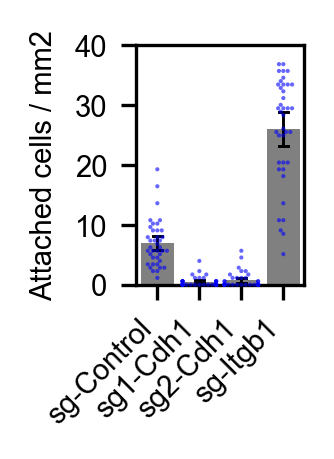

In [10]:
outputPrefix = "cell_attachment_Ecad_coating_1h"
# outputFigPath = "../jupyter_figures/" + outputPrefix + ".svg"
outputFigPath = "../jupyter_figures/" + outputPrefix + ".png"
plotDensityBarSwarm(df.sgRNA, df.cell_density, outputFigPath, yTickSpacing=10)


In [11]:
# Read in and clean up the data for 3 hour fixed E-cadherin coated surface
# 
# Each spreadsheet contains two columns: file name and the cell counts
#
# Each experimental condition has 3 replicates (3 wells), each well we had 
# taken 13 fields of view images.
# 
# Nomenclature:
#
# cell_line    D193    D267     D266     D301
# cell_id*     1       2        3        4
# sgRNA        Control sg1-Cdh1 sg2-Cdh1 sg-Itgb1
#
# * cell_id is used for denoting the wells.
# For example, 1-1, 1-2, 1-3 and 1-4 denote 4 wells (replicates) for cell line #1, which is D193

f1 = "../data/cell-attachment-assay-count-data/20200203-D193-top-D301-bottom-Ecad-splitPositions-cell-counts.txt"
df = pd.read_csv(f1, header=0, sep="\t")
incubation_time = 2 * 3 * 13 * ["3h"]
cell_line = 3 * 13 * ["D193"] + 3 * 13 * ["D301"]
sgRNA = 3 * 13 * ["sg-Control"] + 3 * 13 * ["sg-Itgb1"]
wells = 13 * ["1-1"] + 13 * ["1-2"] + 13 * ["1-3"] + 13 * ["4-1"] + 13 * ["4-2"] + 13 * ["4-3"]
df["incubation_time"] = incubation_time
df["cell_line"] = cell_line
df["sgRNA"] = sgRNA
df["wells"] = wells
df1 = df

f2 = "../data/cell-attachment-assay-count-data/20200203-D266-top-D267-bottom-Ecad-splitPositions-cell-counts.txt"
df = pd.read_csv(f2, header=0, sep="\t")
incubation_time = 2 * 3 * 13 * ["3h"]
cell_line = 3 * 13 * ["D266"] + 3 * 13 * ["D267"]
sgRNA = 3 * 13 * ["sg2-Cdh1"] + 3 * 13 * ["sg1-Cdh1"]
wells = 13 * ["3-1"] + 13 * ["3-2"] + 13 * ["3-3"] + 13 * ["2-1"] + 13 * ["2-2"] + 13 * ["2-3"]
df["incubation_time"] = incubation_time
df["cell_line"] = cell_line
df["sgRNA"] = sgRNA
df["wells"] = wells
df2 = df

df = pd.concat([df1, df2])
df.reset_index(inplace=True)
df.sort_values(by="cell_line", inplace=True)
df["cell_density"] = df.cell_number / FOV_AREA
df_Ecad_3h = df


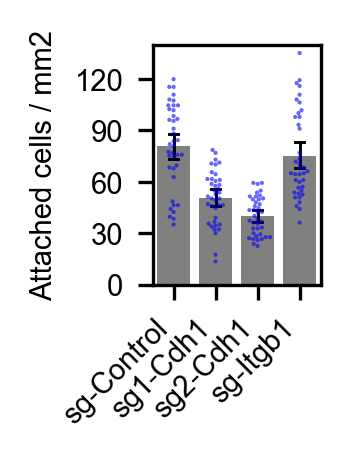

In [12]:
outputPrefix = "cell_attachment_Ecad_coating_3h"
# outputFigPath = "../jupyter_figures/" + outputPrefix + ".svg"
outputFigPath = "../jupyter_figures/" + outputPrefix + ".png"
plotDensityBarSwarm(df.sgRNA, df.cell_density, outputFigPath, yTickSpacing=30)


In [13]:
df = df_Ecad_1h
tukeyTest(df.cell_number, df.sgRNA)
df = df_Ecad_2h
tukeyTest(df.cell_number, df.sgRNA)
df = df_Ecad_3h
tukeyTest(df.cell_number, df.sgRNA)


Summary of test:
     Multiple Comparison of Means - Tukey HSD, FWER=0.05    
  group1    group2  meandiff p-adj  lower    upper   reject
-----------------------------------------------------------
sg-Control sg-Itgb1   33.641 0.001  28.5775  38.7046   True
sg-Control sg1-Cdh1  -11.359 0.001 -16.4225  -6.2954   True
sg-Control sg2-Cdh1 -10.9231 0.001 -15.9866  -5.8595   True
  sg-Itgb1 sg1-Cdh1    -45.0 0.001 -50.0636 -39.9364   True
  sg-Itgb1 sg2-Cdh1 -44.5641 0.001 -49.6277 -39.5005   True
  sg1-Cdh1 sg2-Cdh1   0.4359   0.9  -4.6277   5.4995  False
-----------------------------------------------------------
p values of all pair-wise tests:
 [0.001 0.001 0.001 0.001 0.001 0.9  ]
Summary of test:
      Multiple Comparison of Means - Tukey HSD, FWER=0.05      
  group1    group2   meandiff p-adj    lower    upper   reject
--------------------------------------------------------------
sg-Control sg-Itgb1   22.1923 0.0027    6.0111  38.3736   True
sg-Control sg1-Cdh1  -79.7244  0.001  -9

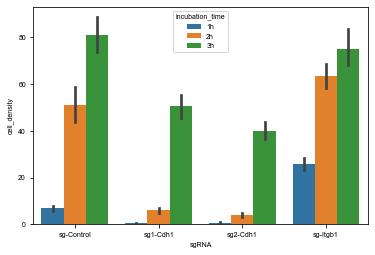

In [14]:
df = pd.concat([df_Ecad_1h, df_Ecad_2h, df_Ecad_3h])
plot_order=["sg-Control", "sg1-Cdh1", "sg2-Cdh1", "sg-Itgb1"]
sns.barplot(data=df, x="sgRNA", y="cell_density", hue="incubation_time", order=plot_order)

outputPrefix = "cell_attachment_Ecad_coating_all_time_points"
# outputFigPath = "../jupyter_figures/" + outputPrefix + ".svg"
outputFigPath = "../jupyter_figures/" + outputPrefix + ".png"
plt.savefig(outputFigPath)


In [15]:
# Read in and clean up the data for 15-min fixed Matrigel (MG) coated surface
# 
# Each spreadsheet contains two columns: file name and the cell counts
#
# Each experimental condition has 3 replicates (3 wells), each well we had 
# taken 13 fields of view images.
# 
# Nomenclature:
#
# cell_line    D193    D267     D266     D301
# cell_id*     1       2        3        4
# sgRNA        Control sg1-Cdh1 sg2-Cdh1 sg-Itgb1
#
# * cell_id is used for denoting the wells.
# For example, 1-1, 1-2, 1-3 and 1-4 denote 4 wells (replicates) for cell line #1, which is D193

f1 = "../data/cell-attachment-assay-count-data/20200203-D193-top-D301-bottom-MG-splitPositions-cell-counts.txt"
df = pd.read_csv(f1, header=0, sep="\t")
incubation_time = 2 * 3 * 13 * ["15_min"]
cell_line = 3 * 13 * ["D193"] + 3 * 13 * ["D301"]
sgRNA = 3 * 13 * ["sg-Control"] + 3 * 13 * ["sg-Itgb1"]
wells = 13 * ["1-1"] + 13 * ["1-2"] + 13 * ["1-3"] + 13 * ["4-1"] + 13 * ["4-2"] + 13 * ["4-3"]
df["incubation_time"] = incubation_time
df["cell_line"] = cell_line
df["sgRNA"] = sgRNA
df["wells"] = wells
df1 = df

f2 = "../data/cell-attachment-assay-count-data/20200203-D266-top-D267-bottom-MG-splitPositions-cell-counts.txt"
df = pd.read_csv(f2, header=0, sep="\t")
incubation_time = 2 * 3 * 13 * ["15_min"]
cell_line = 3 * 13 * ["D266"] + 3 * 13 * ["D267"]
sgRNA = 3 * 13 * ["sg2-Cdh1"] + 3 * 13 * ["sg1-Cdh1"]
wells = 13 * ["3-1"] + 13 * ["3-2"] + 13 * ["3-3"] + 13 * ["2-1"] + 13 * ["2-2"] + 13 * ["2-3"]
df["incubation_time"] = incubation_time
df["cell_line"] = cell_line
df["sgRNA"] = sgRNA
df["wells"] = wells
df2 = df

df = pd.concat([df1, df2])
df.reset_index(inplace=True)
df.sort_values(by="cell_line", inplace=True)
df["cell_density"] = df.cell_number / FOV_AREA
df_MG_15min = df


In [16]:
df.groupby("sgRNA")["cell_density"].describe()


,count,mean,std,min,25%,50%,75%,max
sgRNA,,,,,,,,
sg-Control,39.0,56.381390,15.995826,36.186153,45.232691,52.583004,62.194951,104.600599
sg-Itgb1,39.0,6.378969,6.317399,1.130817,3.392452,4.523269,6.784904,35.620745
sg1-Cdh1,39.0,53.713821,17.295746,29.966658,40.426718,49.190552,64.739290,92.161609
sg2-Cdh1,39.0,53.887793,18.485060,31.097475,39.861309,50.886778,63.608472,104.600599


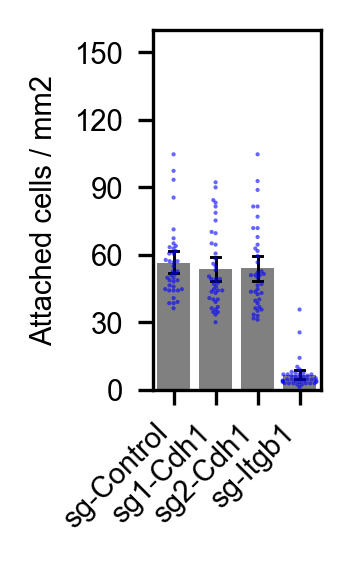

In [17]:
outputPrefix = "cell_attachment_MG_coating_15min_tall"
outputFigPath = "../jupyter_figures/" + outputPrefix + ".svg"
plotDensityBarSwarm(df.sgRNA, df.cell_density, outputFigPath,
                    yTickSpacing=30, yMax=160,
                    fig_width=0.7, fig_height=1.5)


In [18]:
# Save cleaned data for further statistical analysis in R
df['data_to_compare'] = df.cell_density
df['groups'] = df.sgRNA
df.to_csv('../data_cleaned/' + '20200203-MG-coating-cell-attachment-2h.csv')

# Filter out values close to the mean to select representative images
df1 = df[df.cell_number>=82] 
df2 = df1[df1.cell_number<108]
df2


,index,file_name,cell_number,incubation_time,cell_line,sgRNA,wells,cell_density,data_to_compare,groups
23,23,"Plate000_Well2_ChannelMono,GFP_Seq0001-10",90,15_min,D193,sg-Control,1-2,50.886778,50.886778,sg-Control
24,24,"Plate000_Well2_ChannelMono,GFP_Seq0001-11",101,15_min,D193,sg-Control,1-2,57.106273,57.106273,sg-Control
26,26,"Plate000_Well3_ChannelMono,GFP_Seq0002-00",93,15_min,D193,sg-Control,1-3,52.583004,52.583004,sg-Control
28,28,"Plate000_Well3_ChannelMono,GFP_Seq0002-02",88,15_min,D193,sg-Control,1-3,49.755961,49.755961,sg-Control
31,31,"Plate000_Well3_ChannelMono,GFP_Seq0002-05",100,15_min,D193,sg-Control,1-3,56.540864,56.540864,sg-Control
32,32,"Plate000_Well3_ChannelMono,GFP_Seq0002-06",107,15_min,D193,sg-Control,1-3,60.498725,60.498725,sg-Control
33,33,"Plate000_Well3_ChannelMono,GFP_Seq0002-07",82,15_min,D193,sg-Control,1-3,46.363509,46.363509,sg-Control
34,34,"Plate000_Well3_ChannelMono,GFP_Seq0002-08",93,15_min,D193,sg-Control,1-3,52.583004,52.583004,sg-Control
36,36,"Plate000_Well3_ChannelMono,GFP_Seq0002-10",102,15_min,D193,sg-Control,1-3,57.671682,57.671682,sg-Control
37,37,"Plate000_Well3_ChannelMono,GFP_Seq0002-11",101,15_min,D193,sg-Control,1-3,57.106273,57.106273,sg-Control


In [19]:
# Read in and clean up the data for 1 hour (60 min) fixed Matrigel (MG) coated surface
# 
# Each spreadsheet contains two columns: file name and the cell counts
#
# Each experimental condition has 3 replicates (3 wells), each well we had 
# taken 10 fields of view images.
# 
# Nomenclature:
#
# cell_line    D193    D267     D266     D301
# cell_id*     1       2        3        4
# sgRNA        Control sg1-Cdh1 sg2-Cdh1 sg-Itgb1
#
# * cell_id is used for denoting the wells.
# For example, 1-1, 1-2, 1-3 and 1-4 denote 4 wells (replicates) for cell line #1, which is D193

folder = "../data/cell-attachment-assay-count-data/"

f1 = "2020-02-01-1h-fixed-MG-D193-ABA-splitPositions-cell-counts.txt"
df = pd.read_csv(folder + f1, header=0, sep="\t")
incubation_time = 3 * 10 * ["60 min"]
cell_line = 3 * 10 * ["D193"]
sgRNA = 3 * 10 * ["sg-Control"]
wells = 10 * ["1-1"] + 10 * ["1-2"] + 10 * ["1-3"]
df["incubation_time"] = incubation_time
df["cell_line"] = cell_line
df["sgRNA"] = sgRNA
df["wells"] = wells
df1 = df

f2 = "2020-02-01-1h-fixed-MG-D266-ABA-splitPositions-cell-counts.txt"
df = pd.read_csv(folder + f2, header=0, sep="\t")
incubation_time = 3 * 10 * ["60 min"]
cell_line = 3 * 10 * ["D266"]
sgRNA = 3 * 10 * ["sg2-Cdh1"]
wells = 10 * ["3-1"] + 10 * ["3-2"] + 10 * ["3-3"]
df["incubation_time"] = incubation_time
df["cell_line"] = cell_line
df["sgRNA"] = sgRNA
df["wells"] = wells
df2 = df

f3 = "2020-02-01-1h-fixed-MG-D267-ABA-splitPositions-cell-counts.txt"
df = pd.read_csv(folder + f3, header=0, sep="\t")
incubation_time = 3 * 10 * ["60 min"]
cell_line = 3 * 10 * ["D267"]
sgRNA = 3 * 10 * ["sg1-Cdh1"]
wells = 10 * ["2-1"] + 10 * ["2-2"] + 10 * ["2-3"]
df["incubation_time"] = incubation_time
df["cell_line"] = cell_line
df["sgRNA"] = sgRNA
df["wells"] = wells
df3 = df

f4 = "2020-02-01-1h-fixed-MG-D301-ABA-splitPositions-cell-counts.txt"
df = pd.read_csv(folder + f4, header=0, sep="\t")
incubation_time = 3 * 10 * ["60 min"]
cell_line = 3 * 10 * ["D301"]
sgRNA = 3 * 10 * ["sg-Itgb1"]
wells = 10 * ["4-1"] + 10 * ["4-2"] + 10 * ["4-3"]
df["incubation_time"] = incubation_time
df["cell_line"] = cell_line
df["sgRNA"] = sgRNA
df["wells"] = wells
df4 = df

df = pd.concat([df1, df2, df3, df4])
df.reset_index(inplace=True)
df.sort_values(by="cell_line", inplace=True)
df["cell_density"] = df.cell_number / FOV_AREA

# Optional: drop extreme values caused by clustered cells (only 5 in total)
df.drop(df[ df.cell_number > 500 ].index, inplace=True)

df_MG_60min = df


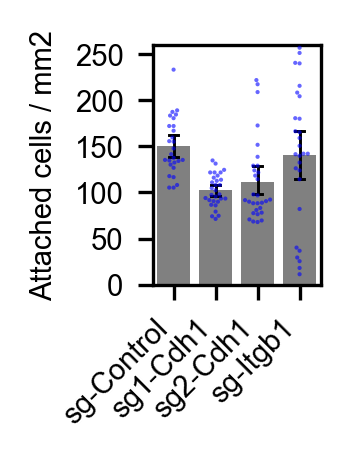

In [20]:
outputPrefix = "cell_attachment_MG_coating_60min"
# outputFigPath = "../jupyter_figures/" + outputPrefix + ".svg"
outputFigPath = "../jupyter_figures/" + outputPrefix + ".png"
plotDensityBarSwarm(df.sgRNA, df.cell_density, outputFigPath, yTickSpacing=50)


In [21]:
des = df_MG_60min.groupby("wells")["cell_number"].describe()
des

,count,mean,std,min,25%,50%,75%,max
wells,,,,,,,,
1-1,9.0,266.888889,43.412108,224.0,239.00,243.0,304.00,334.0
1-2,9.0,284.222222,65.887741,206.0,230.00,282.0,324.00,412.0
1-3,9.0,243.555556,50.122627,186.0,191.00,237.0,274.00,319.0
2-1,10.0,193.300000,29.672471,140.0,170.75,197.5,213.50,238.0
2-2,10.0,178.100000,24.906269,153.0,160.50,169.0,188.50,232.0
2-3,10.0,170.400000,34.448674,126.0,137.00,170.5,198.50,215.0
3-1,10.0,223.100000,92.655215,135.0,156.75,205.5,225.75,392.0
3-2,10.0,187.900000,58.714848,121.0,157.75,162.5,224.75,305.0
3-3,10.0,180.000000,78.724555,120.0,137.25,149.5,172.50,369.0


In [22]:
df = df_MG_15min
tukeyTest(df.cell_number, df.sgRNA)
df = df_MG_60min
tukeyTest(df.cell_number, df.sgRNA)


Summary of test:
      Multiple Comparison of Means - Tukey HSD, FWER=0.05     
  group1    group2  meandiff p-adj    lower    upper   reject
-------------------------------------------------------------
sg-Control sg-Itgb1 -88.4359  0.001 -104.3574 -72.5144   True
sg-Control sg1-Cdh1  -4.7179 0.8534  -20.6394  11.2035  False
sg-Control sg2-Cdh1  -4.4103 0.8814  -20.3317  11.5112  False
  sg-Itgb1 sg1-Cdh1  83.7179  0.001   67.7965  99.6394   True
  sg-Itgb1 sg2-Cdh1  84.0256  0.001   68.1041  99.9471   True
  sg1-Cdh1 sg2-Cdh1   0.3077    0.9  -15.6138  16.2292  False
-------------------------------------------------------------
p values of all pair-wise tests:
 [0.001      0.85337448 0.8814469  0.001      0.001      0.9       ]
Summary of test:
      Multiple Comparison of Means - Tukey HSD, FWER=0.05     
  group1    group2  meandiff p-adj    lower    upper   reject
-------------------------------------------------------------
sg-Control sg-Itgb1  -17.246 0.8458  -74.6865  40.1944  

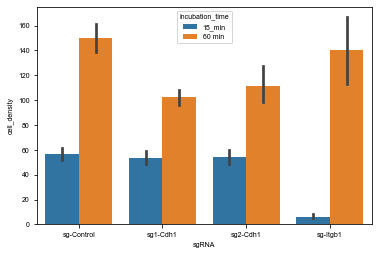

In [23]:
df = pd.concat([df_MG_15min, df_MG_60min])

plot_order=["sg-Control", "sg1-Cdh1", "sg2-Cdh1", "sg-Itgb1"]
sns.barplot(data=df, x="sgRNA", y="cell_density", hue="incubation_time", order=plot_order)

outputPrefix = "cell_attachment_MG_coating_both_time_points"
# outputFigPath = "../jupyter_figures/" + outputPrefix + ".svg"
outputFigPath = "../jupyter_figures/" + outputPrefix + ".png"
plt.savefig(outputFigPath)
